In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import re
import seaborn as sb
sb.set()

In [7]:
def is_experiment_start(line):
    return line.startswith('evaluating for')

def skip_n_experiments(input_file, experiment_num):
    current_experiment = 0
    while current_experiment < experiment_num:
        line = input_file.readline()
        if is_experiment_start(line):
            current_experiment += 1
            
def get_metrics(line):
    regexp = re.compile(r'[a-zA-Z0-9_]+\: [0-9\.]+')
    result = {}
    for metric_str in regexp.findall(line):
        metric, value = metric_str.split(': ')
        result[metric] = float(value)
    return result
    
            
def parse_experiment(experiment_log):
    current_recommender = None
    result = []
    cnt =0
    metrics = []
    experiment_finished = True
    for line in experiment_log:
            if line.startswith('evaluating '):
                current_recommender = line.split(' ')[1]
                metrics = []
                experiment_finished = False
            if 'val_ndcg_at_40' in line:
                    metrics.append(get_metrics(line))
            try:
                experiment_results = json.loads(line)
                experiment_results['model_name'] =  current_recommender
                experiment_results['metrics_history'] = metrics
                result.append(experiment_results)
                experiment_finished = True
            except:
                pass
    if not experiment_finished:
        experiment_results = {}
        experiment_results['model_name'] =  current_recommender
        experiment_results['metrics_history'] = metrics
        result.append(experiment_results)
    return result

def get_data_from_logs(logfile, experiment_num):
    current_experiment = 0
    with open(logfile) as input_file:
        skip_n_experiments(input_file, experiment_num)
        experiment_log = []
        for line in input_file:
            if is_experiment_start(line):
                break
            else:
                experiment_log.append(line.strip())
        return parse_experiment(experiment_log)

In [8]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [9]:
experiment_logs = './results/booking_config_2021_01_22T22_31_58/stdout'
data = get_data_from_logs(experiment_logs, 0)
data

[{'precision@4': 0.01125,
  'SPS@4': 0.045,
  'ndcg@4': 0.02987020549330967,
  'ndcg@40': 0.08171491241883991,
  'model_build_time': 0.12427759170532227,
  'model_inference_time': 0.031807899475097656,
  'model_metadata': {},
  'model_name': 'top_recommender',
  'metrics_history': []},
 {'precision@4': 0.09375,
  'SPS@4': 0.372,
  'ndcg@4': 0.27148758875352147,
  'ndcg@40': 0.34078549140006664,
  'model_build_time': 0.008994102478027344,
  'model_inference_time': 0.03684043884277344,
  'model_metadata': {},
  'model_name': 'conditional_top_recommender',
  'metrics_history': []},
 {'precision@4': 0.06525,
  'SPS@4': 0.261,
  'ndcg@4': 0.19452193957962782,
  'ndcg@40': 0.24444327361297297,
  'model_build_time': 5.007220506668091,
  'model_inference_time': 14.929171085357666,
  'model_metadata': {},
  'model_name': 'svd_recommender',
  'metrics_history': []},
 {'precision@4': 0.11025,
  'SPS@4': 0.441,
  'ndcg@4': 0.34057164810196217,
  'ndcg@40': 0.4283172549743255,
  'model_build_time':

In [10]:
df = pd.DataFrame(data).set_index('model_name').sort_values('SPS@4')
df

,precision@4,SPS@4,ndcg@4,ndcg@40,model_build_time,model_inference_time,model_metadata,metrics_history
model_name,,,,,,,,
top_recommender,0.01125,0.045,0.029870,0.081715,0.124278,0.031808,{},[]
svd_recommender,0.06525,0.261,0.194522,0.244443,5.007221,14.929171,{},[]
conditional_top_recommender,0.09375,0.372,0.271488,0.340785,0.008994,0.036840,{},[]
transitions_chain_recommender,0.11025,0.441,0.340572,0.428317,2.557953,0.587027,{},[]
APREC-GMLPHE-Lambdarank-256-0.5,0.13000,0.520,0.420697,0.498409,32583.024753,45.887683,"{'epochs_trained': 42, 'best_val_ndcg': 0.5123...","[{'loss': 3.9301, 'ndcg_at_40': 0.069, 'Succes..."


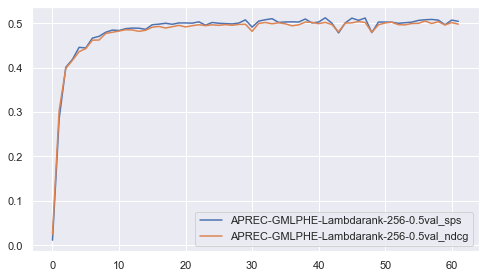

In [11]:
def get_metric(metric_history, metric_name):
    result = []
    for item in metric_history:
        try:
            result.append(item[metric_name])
        except:
            print(item)
    return result

plt.figure(figsize=(8, 4.5))
for recommender in data:
    if len(recommender['metrics_history']) > 0:
        history = recommender['metrics_history']
        ndcg = get_metric(history, 'ndcg_at_40')
        val_ndcg = get_metric(history, 'val_ndcg_at_40')
        
        success = get_metric(history, 'Success_at_4')
        val_success = get_metric(history, 'val_Success_at_4')
        
        plt.plot(val_success, label=recommender['model_name'] + "val_sps")
        #plt.plot(success, label=recommender['model_name'] + "sps")
        
        plt.plot(val_ndcg, label=recommender['model_name'] + "val_ndcg")
        #plt.plot(ndcg, label=recommender['model_name'] + "ndcg")
        #plt.plot(val_success, label=recommender['model_name'] + "_val_sps")
plt.legend()
